In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from utils.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
CLUSTERS = ["cosmos08", "cosmos09", "cosmos14", "cosmos15"]
#CLUSTERS = ["cosmos09", "cosmos15"]

FN_TMP = "../data/{CLUSTER}/op_df.csv"
FN_TMP2 = "../data/{CLUSTER}/expr_df.csv"
#DEDUPFN = FN.replace(".ss.csv", "-dedup.ss.csv")
#AUGMENTED_FN = FN.replace(".ss.csv", "-augmented.ss.csv")

INP_FIELD = "NormInputHashCode"
FILTER_FIELD = "FilterExpr"

WKS = ["job", "tpcds", "tpch", "stack"]
WORKLOADS = {}
WORKLOADS["stack"] = "../data/stack/dfs"
WORKLOADS["tpcds"] = "../data/tpcds/all/dfs/"
WORKLOADS["job"] = "../data/job/all_job/sqls/dfs/"
WORKLOADS["tpch"] = "../data/tpch/all/dfs"

EXPRDF_FIELDS0 = ['jobid', INP_FIELD, 'unique_filter_cols',
       'discrete_ops', 'cont_ops', 'like_ops', 'num_unique_ops', 'num_ops',
       'num_discrete_consts', 'num_likes', 'like_lens', 
        #'workload', 
        'db', 'cluster', "OperatorName", "StageName", "ExclusiveTime",
        'InputCardinality', 'RowCount', 'Selectivity']

# EXPRDF_FIELDS = ['jobid', 'input', 'unique_filter_cols',
#        'discrete_ops', 'cont_ops', 'like_ops', 'num_unique_ops', 'num_ops',
#        'num_discrete_consts', 'num_likes', 'like_lens', 
#         'workload', 
#         'db', 'cluster',
#         'InputCardinality', 'RowCount', 'Selectivity']

OPDF_FIELDS0 = ['op', 'dtype', 'optype', 'constant', 'input', 'column', 'opstring',
       'jobid', 'exprhash',
       #'workload', 
        'db', 'cluster']

OPDF_FIELDS = ['op', 'dtype', 'optype', 'constant', 'input', 'column', 'opstring',
       'jobid', 'exprhash',
       'workload', 'cluster',
        'db']

#DSCOLORS = ["blue", "red", "green", "black"]
DSCOLORS = {}
DSCOLORS["tpcds"] = "red"
DSCOLORS["tpch"] = "purple"
DSCOLORS["job"] = "green"
DSCOLORS["stack"] = "blue"
DSCOLORS["cosmos"] = "grey"

In [27]:
opdfs = []
exprdfs = []

for cluster in CLUSTERS:
    print(cluster)
    fn = FN_TMP.format(CLUSTER=cluster)
    opdfs.append(pd.read_csv(fn, usecols = OPDF_FIELDS0))
    
    fn2 = FN_TMP2.format(CLUSTER=cluster)
    exprdfs.append(pd.read_csv(fn2, usecols = EXPRDF_FIELDS0))

cosmos08


/home/pari/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


cosmos09
cosmos14
cosmos15


/home/pari/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
opdf = pd.concat(opdfs)
exprdf = pd.concat(exprdfs)

In [34]:
print(set(exprdf["cluster"]))

{'cosmos15', 'cosmos09', 'cosmos08', 'cosmos14'}


In [35]:
#exprdf.keys()

In [36]:
exprdf.groupby("cluster")["Selectivity"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
cluster,,,,,,,,,,,
cosmos08,898939.0,0.217881,0.315790,0.0,0.000780,3.885763e-02,0.360000,0.807797,1.0,1.0,1.0
cosmos09,637315.0,0.166903,0.338658,0.0,0.000007,3.861645e-04,0.066395,1.000000,1.0,1.0,1.0
cosmos14,3137816.0,0.105755,0.291549,0.0,0.000000,2.961056e-08,0.000002,0.520948,1.0,1.0,1.0
cosmos15,3078923.0,0.164010,0.324831,0.0,0.000000,1.119668e-03,0.091876,0.939538,1.0,1.0,1.0


In [37]:
exprdf["Stage1"] = exprdf.apply(lambda x: "SV1_" in str(x["StageName"]) ,axis=1)

In [38]:
exprdf.groupby(["Stage1", "cluster"])["Selectivity"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])

count      mean       std  min       25%           50%  \
Stage1 cluster                                                                
False  cosmos08   857670.0  0.219034  0.314785  0.0  0.000720  4.341536e-02   
       cosmos09   604125.0  0.166693  0.338321  0.0  0.000007  3.722512e-04   
       cosmos14  3120988.0  0.105922  0.291886  0.0  0.000000  2.961699e-08   
       cosmos15  3030158.0  0.161795  0.323511  0.0  0.000000  7.745359e-04   
True   cosmos08    41269.0  0.193938  0.335107  0.0  0.001587  1.995611e-02   
       cosmos09    33190.0  0.170714  0.344715  0.0  0.000000  6.047998e-04   
       cosmos14    16828.0  0.074823  0.218188  0.0  0.000000  2.657256e-08   
       cosmos15    48765.0  0.301647  0.373437  0.0  0.006155  8.598913e-02   

                      75%       90%       95%  99%  max  
Stage1 cluster                                           
False  cosmos08  0.362238  0.803506  1.000000  1.0  1.0  
       cosmos09  0.067281  1.000000  1.000000  1.0  1.0  
       cosmos14  0.000002  0.521898  1.000000  1.0  1.0  
       cosmos15  0.084954  0.930244  1.000000  1.0  1.0  
True   cosmos08  0.165258  1.000000  1.000000  1.0  1.0  
       cosmos09  0.054734  1.000000  1.000000  1.0  1.0  
       cosmos14  0.000053  0.234718  0.652463  1.0  1.0  
       cosmos15  0.466515  1.000000  1.000000  1.0  1.0

In [41]:
exprdf.groupby(["Stage1", "cluster"])["ExclusiveTime"].describe(percentiles=[0.25,0.75, 0.90, 0.95, 0.99])

count          mean            std  min    25%    50%  \
Stage1 cluster                                                               
False  cosmos08   857670.0   1440.568324  142045.637202  0.0  0.000  0.016   
       cosmos09   604125.0    569.603371   42462.289024  0.0  0.062  1.627   
       cosmos14  3120988.0    112.474382   12240.257604  0.0  0.000  0.000   
       cosmos15  3030158.0    154.894245   17591.099273  0.0  0.000  0.000   
True   cosmos08    41269.0  10152.469893  350258.781677  0.0  0.000  0.127   
       cosmos09    33190.0   4225.235175  255462.567783  0.0  0.000  0.000   
       cosmos14    16828.0   2394.262540   29454.271533  0.0  0.000  0.015   
       cosmos15    48765.0   1576.318097   53244.218246  0.0  0.031  0.891   

                     75%       90%         95%          99%           max  
Stage1 cluster                                                             
False  cosmos08   1.1150   18.7091   154.99210   2872.94813  5.420516e+07  
       cosmos09   6.3270   44.8746   345.74940  12946.77384  1.899378e+07  
       cosmos14   0.0310    0.0940     0.96800     53.99513  3.968888e+06  
       cosmos15   0.2370    8.1030    31.01900    920.50948  1.153834e+07  
True   cosmos08   3.4240  220.8784  1249.83820  48857.27064  3.691864e+07  
       cosmos09   0.3525   58.4988   285.14815  28594.79567  3.781254e+07  
       cosmos14   0.3150   94.0182   954.75750  38007.80246  1.274508e+06  
       cosmos15  92.6190  710.8762  1870.88080  17802.92868  4.128003e+06

In [42]:
exprdf["workload"] = "cosmos"
exprdf = exprdf.rename(columns={INP_FIELD:"input"})

In [43]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 100)

In [44]:
exprdf = exprdf[exprdf.Stage1 == True]

# Discrete vs Continuous etc

In [45]:
dbcounts = exprdf.groupby("db").count()["jobid"].reset_index().sort_values(by="jobid", ascending=False)
dbcounts["jobid"].describe(percentiles=[0.9,0.99])

count    16063.000000
mean         8.718919
std        136.925628
min          1.000000
50%          1.000000
90%          5.000000
99%         55.380000
max      10775.000000
Name: jobid, dtype: float64

In [46]:
seldbs = dbcounts[dbcounts["jobid"] >= 10]["db"].values
seldbs = list(seldbs) + WKS
dbmeans = exprdf.groupby(["db", "cluster", "workload"])[["cont_ops", "discrete_ops", "like_ops"]].mean().reset_index()
dbmeans = dbmeans[dbmeans.db.isin(seldbs)]

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


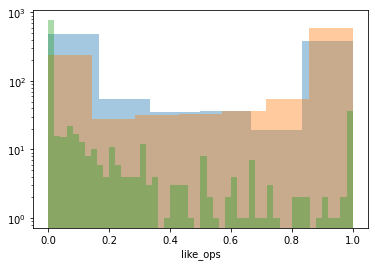

In [47]:
sns.distplot(dbmeans["cont_ops"], kde=False)
sns.distplot(dbmeans["discrete_ops"], kde=False)
sns.distplot(dbmeans["like_ops"], kde=False)
plt.yscale("log")

In [48]:
wedf.groupby("workload")[["cont_ops", "discrete_ops", "like_ops"]].mean()

,cont_ops,discrete_ops,like_ops
workload,,,
job,0.142066,0.706642,0.225092
stack,0.371122,0.608536,0.105979
tpcds,0.400763,0.709924,0.003817
tpch,0.473684,0.552632,0.078947


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


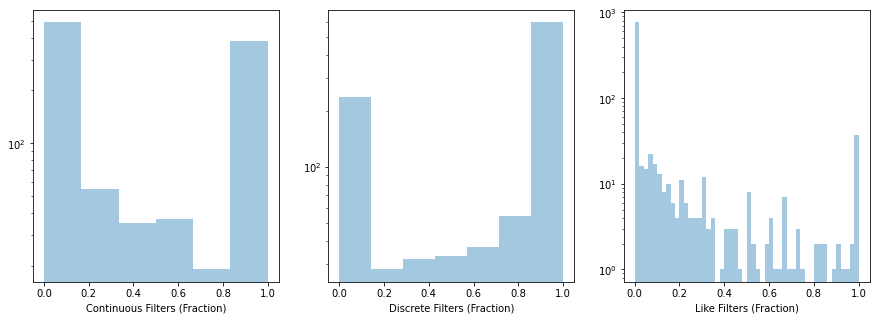

In [49]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax = axs[0]
sns.distplot(dbmeans["cont_ops"], kde=False, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Continuous Filters (Fraction)")

ax = axs[1]
sns.distplot(dbmeans["discrete_ops"], kde=False, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Discrete Filters (Fraction)")

ax = axs[2]
sns.distplot(dbmeans["like_ops"], kde=False)
ax.set_yscale("log")
ax.set_xlabel("Like Filters (Fraction)")

plt.savefig("Filter-Type-Distributions.png")

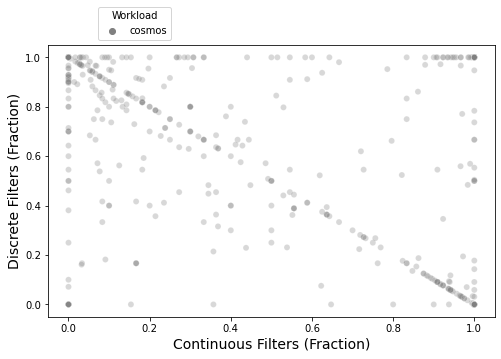

In [50]:
means1 = dbmeans[dbmeans.workload == "cosmos"]
means2 = dbmeans[dbmeans.workload != "cosmos"]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))

sns.scatterplot(data=means1, x="cont_ops", y="discrete_ops", alpha=0.3, hue="workload", palette=["grey"])
sns.scatterplot(data=means2, x="cont_ops", y="discrete_ops", alpha=1.0, hue="workload", s=100, palette=DSCOLORS)

ax.legend(title="Workload", bbox_to_anchor=(0.1, 1.00), ncol=5,
         frameon = True, fontsize=10)
ax.set_ylabel("Discrete Filters (Fraction)", fontsize=14)
ax.set_xlabel("Continuous Filters (Fraction)", fontsize=14)

plt.savefig("Discrete-Continuous.png", dpi=200)
plt.show()

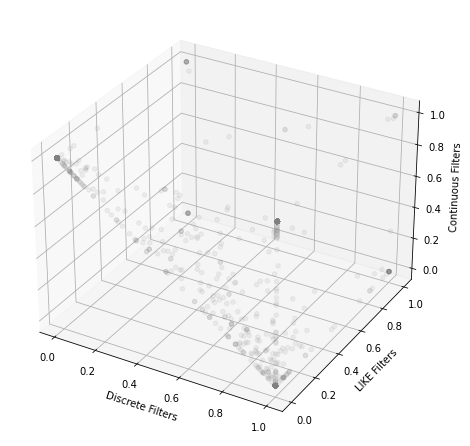

In [51]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


x = means1["discrete_ops"]
y = means1["like_ops"]
z = means1["cont_ops"]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# plot
sc = ax.scatter(x, y, z, s=20, marker='o', color="grey", alpha=0.1)

x2 = means2["discrete_ops"]
y2 = means2["like_ops"]
z2 = means2["cont_ops"]

cols = []
for db in means2["db"].values:
    cols.append(DSCOLORS[db])

sc = ax.scatter(x2, y2, z2, s=100, marker='o', color=cols, alpha=1.0)

#for wk in set(means2["workload"]):

ax.set_zlabel('Continuous Filters')
ax.set_xlabel('Discrete Filters')
ax.set_ylabel('LIKE Filters')

# legend
#plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
#plt.savefig("scatter_hue", bbox_inches='tight')

plt.savefig("Discrete-Continuous-Like.png", dpi=200)

# Number of discrete constants

In [52]:
opdf = opdf[~opdf.constant.isna()]

In [53]:
print(set(opdf["cluster"]))

{'cosmos15', 'cosmos09', 'cosmos08', 'cosmos14'}


In [54]:
discdf = opdf[opdf.op.isin(["!=", "="])]
discdf = discdf[~discdf.constant.str.contains("null")]
#print(len(discdf))

In [454]:
print(len(set(discdf["column"])))
#print(len(set(discdf["column"])))

80764


In [455]:
cdf = discdf.groupby(["column", "db", "workload", "cluster"])["constant"].nunique().reset_index()

In [456]:
cdf.sort_values(by="constant", ascending=False)

,column,db,workload,cluster,constant
206462,Id,stack,stack,stack,47192
180950,530496534tenant_id:,cosmos14-1574743,cosmos,cosmos14,9854
100075,1042378059tenant_id:,cosmos14-1574743,cosmos,cosmos14,9820
180728,530496534tenant_id:,cosmos14-11338051,cosmos,cosmos14,9012
181566,530496534tenant_id:,cosmos14-24732432,cosmos,cosmos14,8775
...,...,...,...,...,...
76035,-602448903,cosmos09-63420387,cosmos,cosmos09,1
76036,-602448903,cosmos09-63420395,cosmos,cosmos09,1
76037,-602448903,cosmos09-63420398,cosmos,cosmos09,1
76038,-602448903,cosmos09-6342040,cosmos,cosmos09,1


In [378]:
print(len(set(cdf["column"])))

32880


In [379]:
cdf = cdf[cdf.db.isin(seldbs)]
print(len(set(cdf["column"])))

32313


In [380]:
cdf.groupby(["workload"])["constant"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
workload,,,,,,,,
cosmos,172429.0,3.290549,61.892026,1.0,1.0,3.0,28.00,9854.0
job,11.0,10.909091,11.878169,2.0,7.0,33.0,33.90,34.0
stack,259.0,324.069498,4044.246956,1.0,2.0,36.8,3890.66,64643.0
tpcds,63.0,10.539683,51.237532,1.0,2.0,11.0,169.06,409.0
tpch,17.0,2.764706,3.211881,1.0,1.0,5.8,12.04,13.0


In [381]:
cdf.groupby(["cluster"])["constant"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
cluster,,,,,,,,
cosmos08,64608.0,2.002894,6.574529,1.0,1.0,3.0,18.00,429.0
cosmos09,38308.0,1.686697,3.772133,1.0,1.0,2.0,13.00,193.0
cosmos14,7342.0,28.439390,295.720156,1.0,1.0,24.0,476.59,9854.0
cosmos15,62171.0,2.647006,12.884298,1.0,1.0,3.0,29.00,1155.0
job,11.0,10.909091,11.878169,2.0,7.0,33.0,33.90,34.0
stack,259.0,324.069498,4044.246956,1.0,2.0,36.8,3890.66,64643.0
tpcds,63.0,10.539683,51.237532,1.0,2.0,11.0,169.06,409.0
tpch,17.0,2.764706,3.211881,1.0,1.0,5.8,12.04,13.0


/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


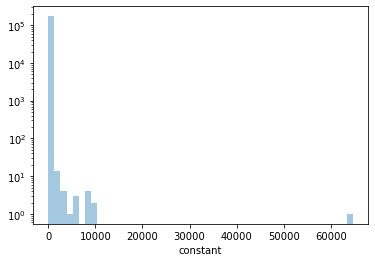

In [382]:
sns.distplot(cdf["constant"], kde=False)
plt.yscale("log")

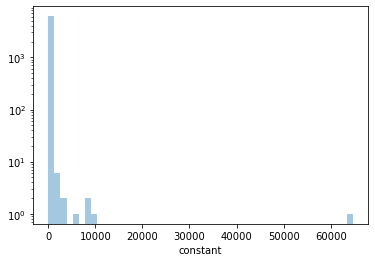

In [383]:
dbconsts = cdf.groupby("db")["constant"].max().reset_index()
sns.distplot(dbconsts["constant"], kde=False)
plt.yscale("log")

# Discrete Predicates on ID columns

In [384]:
def check_id(row):
    col = row["column"].lower()
    if "id" in col and is_int(row["constant"]):
        return True
    else:
        return False

In [385]:
#discdf["is_id"] = discdf.apply(lambda x: check_id(x) ,axis=1)

In [386]:
# iddf = discdf[discdf.is_id == True]
# set(iddf["column"])

# Number of unique LIKE constants (and showing how common they are across multiple inputs etc.)

In [387]:
likedf = opdf[opdf.op.isin(["LIKE"])]
print(len(likedf))
#likedf = likedf.drop_duplicates(["constant", "input", "column", "db"])
#print(len(likedf))
likedf = likedf[likedf.workload == "cosmos"]

546527


In [388]:
# tmp = likedf[likedf.constant == "ndrcode"]
# tmp

In [389]:
print(len(likedf))
print(len(set(likedf["constant"])))

513232
6117


In [390]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [391]:
HTML(likedf.groupby(["constant"])["op"].count().reset_index().sort_values(by="op", ascending=False).head(100).to_html())

,constant,op
4070,ndrcode,55599
1343,actorids,40830
4128,no_dump,39308
1671,bad_dump,39308
3880,missing_dump,39308
5243,tags,22599
5163,states,22597
5301,te.processhost.exe,20905
3746,measures,18233
5376,timesinms,18233


In [392]:
likedf = opdf[opdf.op.isin(["LIKE"])]
print(len(likedf))
#likedf = likedf.drop_duplicates(["constant", "input", "column", "db"])
#print(len(likedf))
likedf = likedf[likedf.workload == "job"]

546527


In [393]:
print(len(likedf))
print(len(set(likedf["constant"])))

194
75


In [394]:
HTML(likedf.groupby(["constant"])["op"].count().reset_index().sort_values(by="op", ascending=False).head(100).to_html())

,constant,op
8,'%(USA)%',14
1,'%(200%)%',10
25,'%Film%',8
44,'%follow%',8
39,'%Warner%',8
46,'%internet%',7
18,'%An%',7
24,'%Downey%Robert%',6
49,'%sequel%',6
43,'%complete%',6


In [457]:
likedf = opdf[opdf.op.isin(["LIKE"])]
tmp = likedf.groupby(["workload", "constant"])["op"].count().reset_index()

In [458]:
tmp.groupby(["workload"])["op"].describe(percentiles=[0.9, 0.99])

,count,mean,std,min,50%,90%,99%,max
workload,,,,,,,,
cosmos,6117.0,83.902567,1402.113586,1.0,2.0,16.0,1226.00,55599.0
job,75.0,2.586667,2.563219,1.0,1.0,6.0,11.04,14.0
stack,1300.0,4.664615,8.420336,1.0,2.0,10.0,38.03,122.0
tpcds,1.0,1.000000,NaN,1.0,1.0,1.0,1.00,1.0
tpch,3.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0


# Selectivity Patterns

### Multidimensional filters ---> dramatically less selectivity (is this matched in multidimensional filters on other dbs?)

### LIKE filters ---> a lot less selectivity; seems unlikely to match in JOB and CEB and others

# Number of unique filter columns per job

In [459]:
exprdf.keys()

Index(['jobid', 'input', 'unique_filter_cols', 'discrete_ops', 'cont_ops',
       'like_ops', 'num_unique_ops', 'num_ops', 'num_discrete_consts',
       'num_likes', 'like_lens', 'workload', 'db', 'cluster',
       'InputCardinality', 'RowCount', 'Selectivity'],
      dtype='object')

In [460]:
exprdf = exprdf[~exprdf.input.isin(["X", "function"])]

In [461]:
exprdf.groupby("workload")["unique_filter_cols"].describe(percentiles=[0.75, 0.9, 0.99, 0.999])

,count,mean,std,min,50%,75%,90%,99%,99.9%,max
workload,,,,,,,,,,
cosmos,7752993.0,1.369419,0.880474,1.0,1.0,1.0,2.0,5.00,8.000,38.0
job,542.0,1.071956,0.258653,1.0,1.0,1.0,1.0,2.00,2.000,2.0
stack,33035.0,1.168155,0.527987,1.0,1.0,1.0,2.0,4.00,5.000,6.0
tpcds,249.0,1.493976,0.696306,1.0,1.0,2.0,2.0,3.52,4.752,5.0
tpch,35.0,1.257143,0.610827,1.0,1.0,1.0,2.0,3.00,3.000,3.0


In [400]:
seldbs = dbcounts[dbcounts["jobid"] >= 10]["db"].values
#seldbs = list(seldbs) + WKS

In [401]:
print(len(seldbs))

6352


In [462]:
dbfiltercols = cdf.groupby("input")["unique_filter_cols"].max().reset_index()
#dbfiltercols = dbfiltercols[dbfiltercols.db.isin(seldbs)]

KeyError: 'input'

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


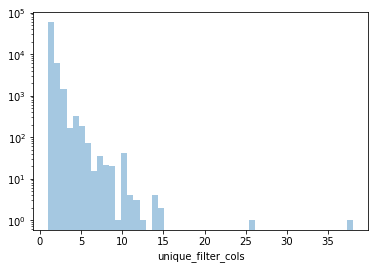

In [463]:
sns.distplot(dbfiltercols["unique_filter_cols"], kde=False)
plt.yscale("log")
#plt.xscale("log")

In [464]:
cdf.groupby(["input", "workload"])["unique_filter_cols"].max().reset_index()

KeyError: 'input'

In [465]:
dbfiltercols = cdf.groupby("input")["unique_filter_cols"].mean().reset_index()
#dbfiltercols = dbfiltercols[dbfiltercols.db.isin(seldbs)]

KeyError: 'input'

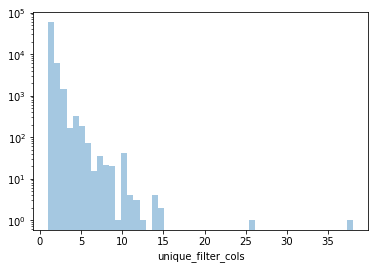

In [466]:
sns.distplot(dbfiltercols["unique_filter_cols"], kde=False)
plt.yscale("log")
#plt.xscale("log")

In [467]:
def pretty_print(df):
    return display( HTML( df.to_html(index=False).replace("\\n","<br>") ) )

In [468]:
# #STATCOLS = ["ExclusiveTime", "Selectivity", "QError", "VertexCount", "exploratory_job", "templated_job"]
# STATSTODROP = ["std", "min", "max"]
# STATCOLS = ["Selectivity", "InputCardinality"]
# curdrops = []
# for si, stc in enumerate(STATCOLS):
#     for sdrop in STATSTODROP:
#         curdrops.append(tuple([stc, sdrop]))
#     if si != 0:
#         curdrops.append(tuple([stc,"count"]))

# #curdrops.append(tuple(["QError","mean"]))
# #curdrops.append(tuple(["VertexCount","mean"]))
# #print(curdrops)
# pretty_print(cdf.groupby(["unique_filter_cols"])[STATCOLS].describe(percentiles=[0.9, 0.99]).\
#      reset_index().\
#      #.sort_values(by=("Selectivity","count"), ascending=False).\
#      rename(columns={"cont_ops":"> or <", "discrete_ops":"=,!=", "like_ops":"LIKE"}).\
#      drop(columns=curdrops).round(2))

# Multi-Dimensional Filter Kinds

In [469]:
multidf = exprdf[exprdf.unique_filter_cols == 2]

In [410]:
def kind_multi_dim_index(row):
    kinds = []
    if row["discrete_ops"] == 1:
        kinds.append("discrete")
        
    if row["cont_ops"] == 1:
        kinds.append("cont")
        
    if row["like_ops"] == 1:
        kinds.append("like")
    
    kinds.sort()
    return ",".join(kinds)

In [411]:
multidf["multikind"] = multidf.apply(lambda x: kind_multi_dim_index(x) , axis=1)

/tmp/ipykernel_3025675/319002343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multidf["multikind"] = multidf.apply(lambda x: kind_multi_dim_index(x) , axis=1)


In [412]:
multidf.groupby("multikind")["jobid"].describe()

,count,unique,top,freq
multikind,,,,
cont,54090,12860,84beead7-4626-4aec-9081-736a97feb48e,1655
"cont,discrete",436437,49210,ad49cde6-c115-44e3-99f2-e7239dc14f77,1620
"cont,discrete,like",1045,643,323821e3-e4c2-4bad-abb5-b7153f687fd3,2
"cont,like",67507,2317,023e8161-2ea1-42ab-b6b1-a2d62d8ab05c,848
discrete,339091,36505,558784e6-15eb-4414-883e-63fdc393e94d,2177
"discrete,like",95436,5423,20fe1d3d-2a75-45bf-9dd5-0114c62547ce,7473
like,1133,1001,ebb7b2c2-b3ef-4606-95f0-9dd1df03cb5a,42


In [413]:
multidf.groupby(["workload", "multikind"])["jobid"].describe()

count unique  \
workload multikind                           
cosmos   cont                 54084  12856   
         cont,discrete       436416  49192   
         cont,discrete,like    1045    643   
         cont,like            67501   2311   
         discrete            339035  36468   
         discrete,like        95410   5398   
         like                  1127    995   
job      cont,like              6.0    6.0   
         discrete               2.0    2.0   
         discrete,like         25.0   24.0   
         like                   6.0    6.0   
stack    cont                     0      0   
         cont,discrete            0      0   
         cont,discrete,like       0      0   
         cont,like                0      0   
         discrete                 0      0   
         discrete,like            0      0   
         like                     0      0   
tpcds    cont                   6.0    4.0   
         cont,discrete         20.0   17.0   
         discrete              53.0   36.0   
tpch     cont,discrete          1.0    1.0   
         discrete               1.0    1.0   
         discrete,like          1.0    1.0   

                                                              top  freq  
workload multikind                                                       
cosmos   cont                84beead7-4626-4aec-9081-736a97feb48e  1655  
         cont,discrete       ad49cde6-c115-44e3-99f2-e7239dc14f77  1620  
         cont,discrete,like  323821e3-e4c2-4bad-abb5-b7153f687fd3     2  
         cont,like           2ef91502-8b50-4ef8-96cd-b3be36ff3974   848  
         discrete            558784e6-15eb-4414-883e-63fdc393e94d  2177  
         discrete,like       20fe1d3d-2a75-45bf-9dd5-0114c62547ce  7473  
         like                ebb7b2c2-b3ef-4606-95f0-9dd1df03cb5a    42  
job      cont,like                                            4.0   1.0  
         discrete                                             0.0   1.0  
         discrete,like                                      100.0   2.0  
         like                                                 0.0   1.0  
stack    cont                                                 NaN   NaN  
         cont,discrete                                        NaN   NaN  
         cont,discrete,like                                   NaN   NaN  
         cont,like                                            NaN   NaN  
         discrete                                             NaN   NaN  
         discrete,like                                        NaN   NaN  
         like                                                 NaN   NaN  
tpcds    cont                                                25.0   3.0  
         cont,discrete                                       49.0   2.0  
         discrete                                            26.0   3.0  
tpch     cont,discrete                                       11.0   1.0  
         discrete                                             0.0   1.0  
         discrete,like                                       10.0   1.0

# Number of filter columns per input

In [414]:
fcols = opdf.groupby(["input", "workload", "cluster"])["column"].nunique().reset_index()\
    .rename(columns={"column":"AllFilterColumns"})
fcols = fcols[~fcols.input.isin(["X", "function"])]

In [478]:
fcols.groupby(["workload"])["AllFilterColumns"].describe(percentiles=[0.9, 0.99, 0.999])

,count,mean,std,min,50%,90%,99%,99.9%,max
workload,,,,,,,,,
cosmos,62626.0,2.070051,2.886360,1.0,1.0,4.0,13.00,28.000,280.0
job,17.0,1.352941,0.701888,1.0,1.0,2.4,3.00,3.000,3.0
stack,361.0,2.116343,3.864767,1.0,1.0,3.0,18.60,37.640,38.0
tpcds,34.0,3.382353,2.881653,1.0,2.5,8.7,10.34,10.934,11.0
tpch,7.0,3.000000,2.236068,1.0,2.0,5.8,6.88,6.988,7.0


In [480]:
tmp = fcols[fcols["AllFilterColumns"] == 38]
tmp

,input,workload,cluster,AllFilterColumns
38203,480834419,cosmos,cosmos14,38
57313,1782524463,cosmos,cosmos15,38
62437,2134481566,cosmos,cosmos15,38
62936,posts,stack,stack,38


In [279]:
ccols = fcols[fcols.workload == "cosmos"]
dballcols = ccols.groupby("input")["AllFilterColumns"].max().reset_index()
#dballcols = dballcols[dballcols.db.isin(seldbs)]

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


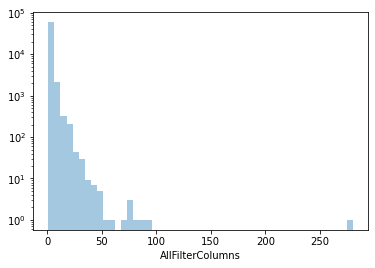

In [280]:
sns.distplot(dballcols["AllFilterColumns"], kde=False)
plt.yscale("log")

# Combine input allcols and uniquefiltercols

In [470]:
udf = exprdf.groupby(["input", "workload"])["unique_filter_cols"].max().reset_index()
#udf = udf[udf.db.isin(seldbs)]

In [471]:
fcols = opdf.groupby(["input", "workload", "cluster"])["column"].nunique().reset_index()\
    .rename(columns={"column":"AllFilterColumns"})
fcols = fcols[~fcols.input.isin(["X", "function"])]
#fcols = fcols[fcols.db.isin(seldbs)]

In [472]:
print(len(set(fcols["input"])), len(set(udf["input"])))

62440 66589


In [473]:
fcols = fcols[fcols.input.isin(udf["input"].values)]

In [474]:
cmb = udf.merge(fcols, on=["input", "workload"])

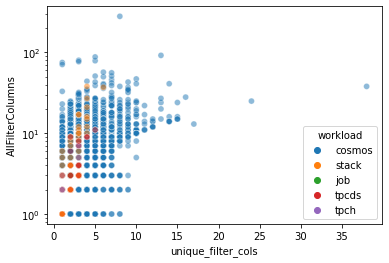

In [475]:
sns.scatterplot(data=cmb, x="unique_filter_cols", y="AllFilterColumns", hue="workload", alpha=0.5)
plt.yscale("log")

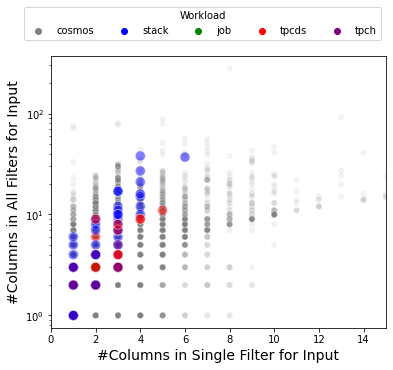

In [476]:
means1 = cmb[cmb.workload == "cosmos"]
means2 = cmb[cmb.workload != "cosmos"]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(6,5))

sns.scatterplot(data=means1, x="unique_filter_cols", y="AllFilterColumns", alpha=0.1, hue="workload", palette=["grey"])
sns.scatterplot(data=means2, x="unique_filter_cols", y="AllFilterColumns", alpha=0.5, hue="workload", 
                s=100, palette=DSCOLORS)

# ax.legend(title="Workload", bbox_to_anchor=(0.20, 1.00), ncol=2,
#          frameon = False, fontsize=14)
ax.legend(title="Workload", bbox_to_anchor=(1, 1.20), ncol=5,
         frameon = True, fontsize=10)
ax.set_yscale("log")
ax.set_xlim([0,15])

ax.set_ylabel("#Columns in All Filters for Input", fontsize=14)
ax.set_xlabel("#Columns in Single Filter for Input", fontsize=14)

plt.savefig("AllColumns-vs-FilterColumn.png", dpi=200)
plt.show()

No handles with labels found to put in legend.


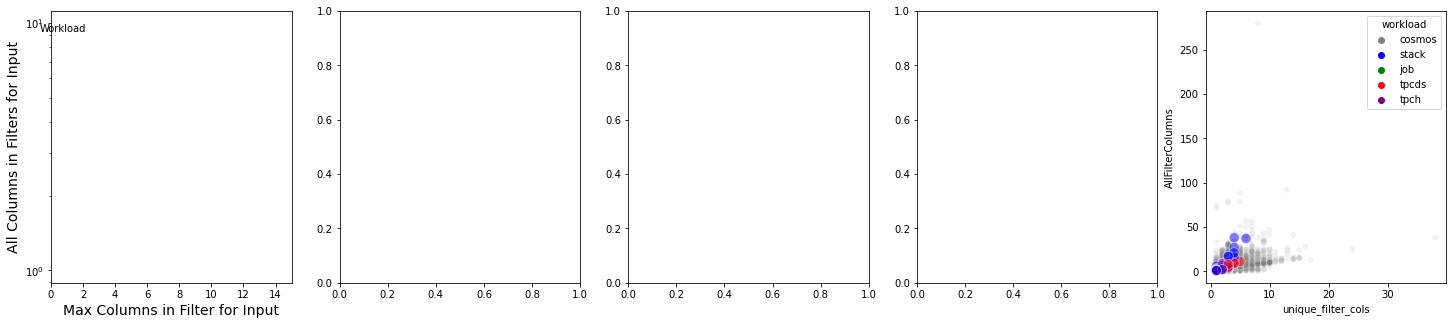

No handles with labels found to put in legend.


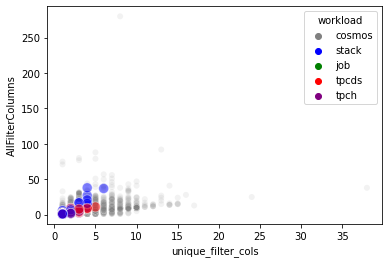

No handles with labels found to put in legend.


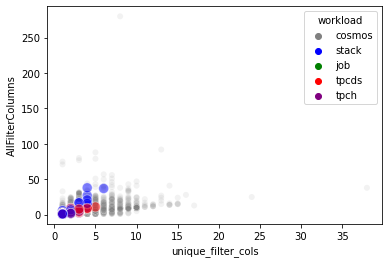

No handles with labels found to put in legend.


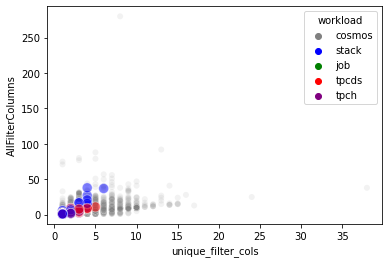

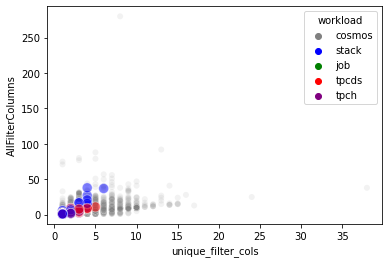

In [477]:
fig,axs = plt.subplots(nrows=1,ncols=5, figsize=(25,5))
for i,wk in enumerate(list(set(cmb["workload"]))):
    tmp = cmb[cmb.workload == wk]
    ax = axs[i]
    sns.scatterplot(data=means1, x="unique_filter_cols", y="AllFilterColumns", alpha=0.1, hue="workload", palette=["grey"])
    sns.scatterplot(data=means2, x="unique_filter_cols", y="AllFilterColumns", alpha=0.5, hue="workload", 
                    s=100, palette=DSCOLORS)

    ax.legend(title="Workload", bbox_to_anchor=(0.20, 1.00), ncol=2,
             frameon = False, fontsize=14)
    ax.set_yscale("log")
    ax.set_xlim([0,15])

    ax.set_ylabel("All Columns in Filters for Input", fontsize=14)
    ax.set_xlabel("Max Columns in Filter for Input", fontsize=14)

    plt.show()